In [1]:
def writeHadoopResults(error, iterations, outputFile, inputName):
    with open(outputFile, 'a+') as f:
        f.write(inputName + ",hadoop,-,-," + iterations + "," + error + ",\n")

In [2]:
def calcElaspedTime(minA, secA, minB, secB):
    if minA == minB:
        return secB - secA
    
    AtoMinute = 60 - secA
    MinDiff = minB - minA - 1
    return AtoMinute + MinDiff*60 + secB

In [82]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib notebook 

In [8]:
def hadoopIterations(filename):
    #TAKES OUTPUT FILE AND GRABS ITER COUNT
    with open(filename) as f:
        finalLine = ""
        for line in f:
            if "final" in line:
                finalLine = line
    value = finalLine.split("-")[-2]
    return int(value) + 1

In [9]:
hadoopIterations("./hadoop/iter_count.txt")

3

In [4]:
with open("small_sep.txt", "w") as f:
    for _ in range(100):
        l = np.random.normal(1, 1, 3).tolist()
        f.write( ' '.join(map(str, l)) + "\n")
        r = np.random.normal(5, 1, 3).tolist()
        f.write( ' '.join(map(str, r))  + "\n")

In [42]:
def hadoopGatherCanopies(filename):
    #GATHER CLUSTER DATA POINTS
    with open(filename) as f:
        clusters = {}
        for line in f:
            if line[0] is '{':
                center = line.split('"c":[')[1]
                center = center.split("]")[0]
                clusters[center] = []
            elif 'distance' in line:
                values = line.strip().split(': [')[-1][:-1]
                clusters[center].append(values)
    return clusters

In [62]:
def hadoopError(filename):
    with open(filename) as f:
        error = 0
        for line in f:
            if 'distance' in line:
                value = line.split("distance=")[1]
                value = value.split(']:')[0]
                error += float(value)
    return error

In [119]:
def plotClusters(canopies, name):
    #PLOTS HADOOP/SPARK CLUSTERS --ONLY USE IF R^3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    for k, v in canopies.items():
        x,y,z = [], [], []
        for pt in v:
            X,Y,Z = list(map( float, pt.split(',') ) )
            x.append(X)
            y.append(Y)
            z.append(Z)
        ax.scatter(x, y, z)

    plt.title(name + " Clusters")
    plt.savefig(name + ".png")

In [120]:
hadoopCanopies = hadoopGatherCanopies("./hadoop/results.txt")

In [121]:
hadoopError("./hadoop/results.txt")

493.1828392436146

<IPython.core.display.Javascript object>


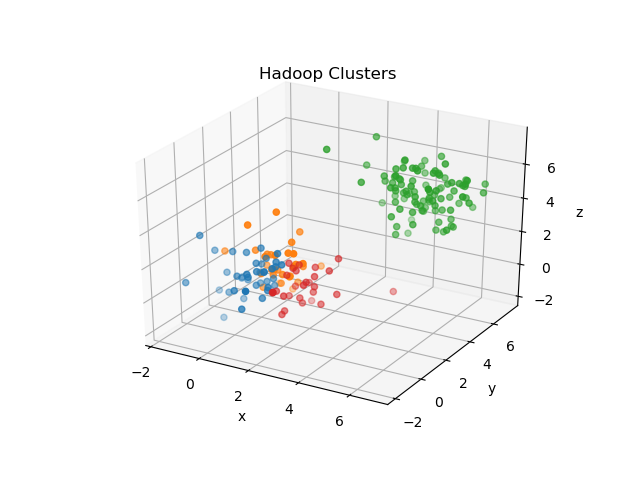

In [122]:
plotClusters(hadoopCanopies, "Hadoop")

In [87]:
def sparkGatherCanopies(centerFile, pointsFile):
    with open(centerFile) as f:
        centers = {}
        for line in f:
            values = line.strip().split('],')
            index = int( values[1][:-1] )
            coord = values[0][2:]
            centers[index] = coord
    with open(pointsFile) as f:
        points = defaultdict(list)
        for line in f:
            values = line.strip().split(",[")
            index = int(values[0][1:])
            coord = values[1][:-2]
            points[index].append(coord)
    canopies = {}
    for k, v in centers.items():
        canopies[v] = points[k]
    return canopies

In [125]:
sparkCanopy = sparkGatherCanopies("./spark/centers.txt", "./spark/points.txt")

<IPython.core.display.Javascript object>


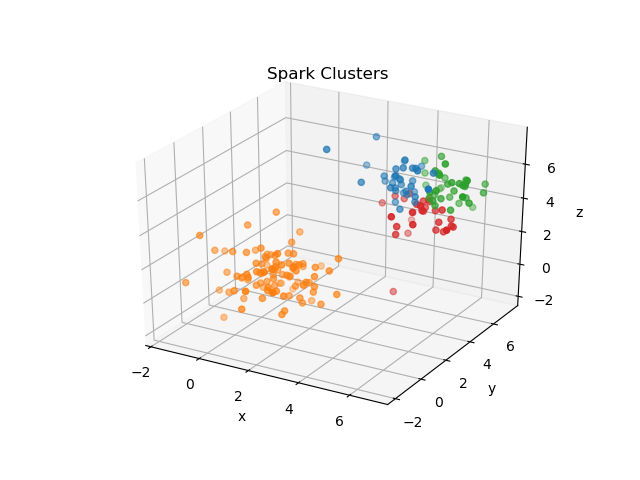

In [126]:
plotClusters(sparkCanopy, "Spark")

In [132]:
def sparkResults(filename, output):
    with open(filename) as f:
        current = f.readlines()[-4:]
        buildTime = current[0].strip().split(" ")[-2] 
        iterTime = current[1].strip().split(" ")[-2] 
        iterations = current[2].strip().split(" ")[-2] 
        cost = current[3].strip()[:-1].split(" ")[-1]
    with open(output, 'a+') as f:
        f.write("spark," + buildTime + "," + iterTime + "," + iterations + "," + cost + ",\n")

In [130]:
sparkResults("./spark/SparkDriver.log", "results.csv")